# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score
import re
import string
import gensim
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
from xgboost import XGBClassifier
import tldextract
from urllib.parse import urlparse

In [8]:
pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.8 MB/s 


In [2]:
df = pd.read_csv('phishing_site_urls.csv')

In [3]:
df.isnull().values.any()

False

In [4]:
df.columns = [x.lower() for x in df.columns]
df.head()

,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [5]:
df['label'].value_counts()

good    392924
bad     156422
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

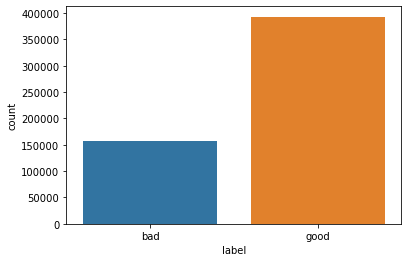

In [6]:
sns.countplot(x="label",data=df)

In [7]:
df['Y'] = df['label'].apply(lambda x: 0 if x == 'good' else 1)

In [8]:
def url_process(url):
    url = re.sub('[^a-zA-Z\ \n]', '.', url.lower())
    url =  re.sub('\.{1,}', ' ', url)
    url = url.split(' ')
    
    stemmer = SnowballStemmer("english")
    url = [stemmer.stem(word) for word in url]
    url = ' '.join(url)
    return url

In [9]:
df['url_clean'] = df['url'].apply(url_process)

In [10]:
df.head()

,url,label,Y,url_clean
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,1,nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,1,www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,1,serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,1,mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,1,thewhiskeydreg com wp content theme widescreen...


# Feature extraction using CountVectorizer

In [11]:
cv=CountVectorizer(ngram_range=(1, 2))

X_train, X_test, y_train, y_test = train_test_split(df['url_clean'], df['Y'], test_size=0.2, random_state=5555)

cv_fit = cv.fit(X_train)
X_train = cv_fit.transform(X_train)

X_test = cv_fit.transform(X_test)

#  Naive Bayes Model

### Baseline Model

In [12]:
from sklearn.naive_bayes import MultinomialNB 

mnb = MultinomialNB()
mnb.fit(X_train, y_train)

print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(X_test), y_test))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     79407
           1       0.94      0.97      0.96     30463

    accuracy                           0.98    109870
   macro avg       0.97      0.97      0.97    109870
weighted avg       0.98      0.98      0.98    109870



In [13]:
grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'fit_prior' : [True, False], 
             'class_prior' : [None, [.1,.9],[.2, .8]]}

gridsearch = GridSearchCV(estimator = mnb, param_grid = grid, scoring = 'roc_auc', cv = 5)
# gridsearch.fit(X_train, y_train)

In [15]:
%%time
##Selecting the best params
from sklearn import metrics
gridsearch.fit(X_train, y_train)

CPU times: total: 1min 18s
Wall time: 1min 18s


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                         'class_prior': [None, [0.1, 0.9], [0.2, 0.8]],
                         'fit_prior': [True, False]},
             scoring='roc_auc')

In [16]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(gridsearch.predict(X_test), y_test))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     78838
           1       0.96      0.96      0.96     31032

    accuracy                           0.98    109870
   macro avg       0.97      0.97      0.97    109870
weighted avg       0.98      0.98      0.98    109870




CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     78838
           1       0.96      0.96      0.96     31032

    accuracy                           0.98    109870
   macro avg       0.97      0.97      0.97    109870
weighted avg       0.98      0.98      0.98    109870


CONFUSION MATRIX


<AxesSubplot:>

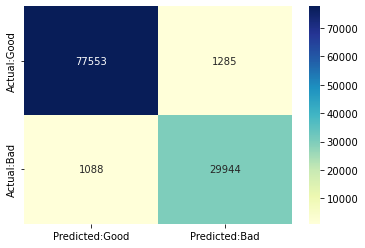

In [19]:
con_mat = pd.DataFrame(confusion_matrix(gridsearch.predict(X_test), y_test),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(gridsearch.predict(X_test), y_test))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# Predicition

In [ ]:
def new_input(url):
    a = url_process(url)
    a_trans = cv_fit.transform(pd.Series(a))
    nb_pred = gridsearch.predict(a_trans)
    
    if nb_pred == 1:
        return 'Bad'
    else:
        return 'Good'

In [ ]:
new_test = 'www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php'

In [ ]:
new_input(df['url'][3])